<a href="https://colab.research.google.com/github/sbalram123/CoronaBatch-Session4/blob/master/SB_CoronaBatch_A5C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Target : 
# 99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
# Less than or equal to 15 Epochs
# Less than 10000 Parameters

# Reduce the number of parameters by changing the architecture while maintaining 99.4% accuracy using 1*1 convolution / removing kernals
# Use image augmentation techniques for better regularization

# Result :
# Parameters: 9,994 Parameters
# Best Train Accuracy: 98.08 (epoch 13)
# Best Test Accuracy: 99.43 (epoch 11)


# Analysis : Drop out settings were made consistent . We also introduced 1*1 convolution layer to manage with higher kernals while keeping number of parameters low
#            We also added bias = False into the architecture to save on some parameters . Batch size was reduced to 64 instead of 128
#            Paramters have increased above the limitation of 10k parameters so this needs to be reduced as well.
#            Image Augmentation - Image Rotation of  [ -6.1 , 6.1 ] used 
#            

kernal	padding	stepsize	nin	nout	rout	jout
0	0	0		0	28	1	1
3	0	1		28	26	3	1
3	0	1		26	24	5	1
1	0	1		24	24	5	1
2	0	2		24	12	6	1
3	0	1		12	10	10	2
3	0	1		10	8	14	2
3	0	1		8	6	18	2
3	1	1		6	6	22	2
6	0	6		6	1	28	2
1	0	1		1	1	28	12

In [0]:
# The gods
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.RandomRotation((-6.2, 6.2), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
dropout = 0.09
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 10, 3,bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(10),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.Conv2d(10, 20, 3,bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(20),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(20, 10, 1,bias=False),

                                   nn.MaxPool2d(2, 2),

                                   nn.Conv2d(10, 20, 3,bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(20),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(20, 16, 3,bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(16),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.Conv2d(16, 10, 3,bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(10),
                                   nn.Dropout2d(dropout),

                                   nn.Conv2d(10, 16, 3,padding =1,bias=False),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(16),
                                   nn.Dropout2d(dropout),
                                   
                                   nn.AvgPool2d(kernel_size=6),
                                   nn.Conv2d(16, 10, 1,bias=False))

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
        Dropout2d-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.94)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.08924659341573715 Batch_id=937 Accuracy=85.84: 100%|██████████| 938/938 [00:21<00:00, 43.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9836/10000 (98.36%)

EPOCH: 1


Loss=0.08142313361167908 Batch_id=937 Accuracy=95.66: 100%|██████████| 938/938 [00:20<00:00, 45.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9882/10000 (98.82%)

EPOCH: 2


Loss=0.4020392596721649 Batch_id=937 Accuracy=96.71: 100%|██████████| 938/938 [00:20<00:00, 45.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.02102579176425934 Batch_id=937 Accuracy=97.18: 100%|██████████| 938/938 [00:20<00:00, 45.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.036943137645721436 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:20<00:00, 46.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.01663951575756073 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [00:20<00:00, 46.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.020438864827156067 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:20<00:00, 46.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.0175599604845047 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:20<00:00, 46.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.104326531291008 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:20<00:00, 45.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.030845120549201965 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:20<00:00, 46.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.02969333529472351 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:21<00:00, 44.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.09259691834449768 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:20<00:00, 46.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.12303276360034943 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:20<00:00, 46.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.11215578019618988 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:20<00:00, 45.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.0031574666500091553 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:19<00:00, 47.41it/s]



Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

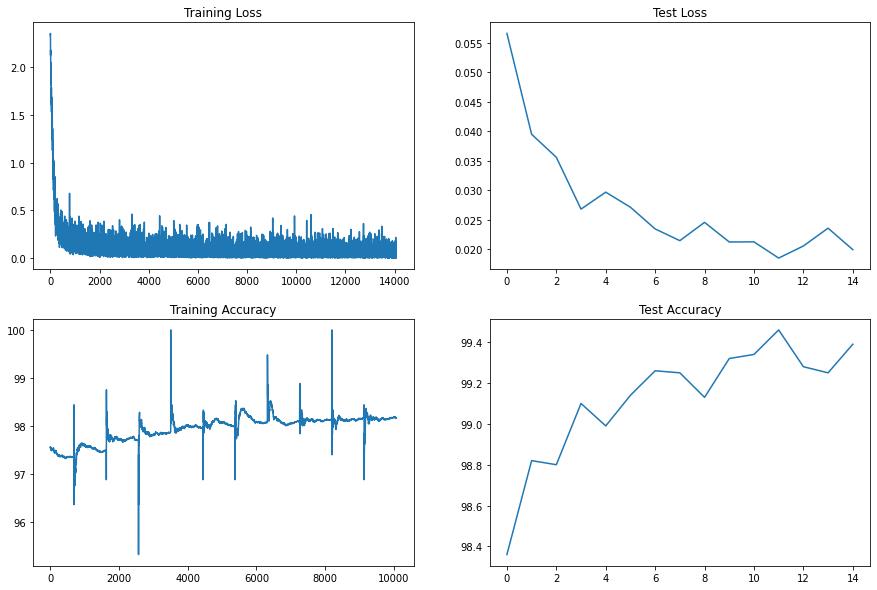

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")